# Reading-in and Downloading ALS Vendor DEM and LPC Products

* coincident.io.xarray
    * load_usgs_dem
        * read a 1m USGS DEM into memory via odc-stac. Option to coarsen and clip
    * load_neon_dem
        * read a 1m NEON DTM, DSM, or CHM into memory via odc-stac. Option to coarsen and clip
    * load_noaa_dem
        * read a 1m NOAA DEM (from the [NOAA Digital Coast Raster](https://coast.noaa.gov/htdata/raster1/) catalog) into memory via odc-stac. Option to coarsen and clip
    * load_ncalm_dem
        * read a 1m NCALM DSM or DTM into memory via odc-stac. Option to coarsen and clip. Note that these files are not tiled

* coincident.io.download
    * download_usgs_dem
        * download a 1m USGS DEM (epsg 4326) to a local directory, option to save STAC-like tiled metadata as geoparquet to the same directory
    * download_neon_dem
        * download a 1m NEON DTM, DSM, or CHM (UTM zone) to a local directory
    * download_noaa_dem
        * download a 1m NOAA DEM (UTM zone) from the [NOAA Digital Coast Raster](https://coast.noaa.gov/htdata/raster1/) catalog to a local directory
    * download_ncalm_dem
        * download a 1m NCALM DSM or DTM (UTM zone) to a local directory. Note that these files are not tiled
    * fetch_usgs_lpc_tiles
        * return a GeoDataFrame with the USGS .laz tile filename, download url, and geometry (epsg 4326) for each tile intersecting an input aoi. Option to download as a geojson to local directory
    * fetch_neon_lpc_tiles
        * return a GeoDataFrame with the NEON .laz tile filename, download url, and geometry (epsg 4326) for each tile intersecting an input aoi. Option to download as a geojson to local directory
    * fetch_noaa_lpc_tiles
        * return a GeoDataFrame with the NOAA .laz tile filename, download url, and geometry (epsg 4326) for each tile intersecting an input aoi from the [NOAA Digital Coast Lidar](https://coast.noaa.gov/htdata/lidar1_z/) catalog. Option to download as a geojson to local directory
    * fetch_ncalm_lpc_tiles
        * return a GeoDataFrame with the NCALM .laz tile filename, download url, and geometry (epsg 4326) for each tile intersecting an input aoi. Option to download as a geojson to local directory


> [!NOTE]  
> Coincident does not support the processing of lidar point cloud products due to the required PDAL dependency. Please see the [lidar_tools](https://github.com/uw-cryo/lidar_tools) repository for information on processing the returned GeoDataFrame with lidar point cloud products.

In [1]:
import coincident
import geopandas as gpd
from shapely.geometry import box

%load_ext autoreload
%autoreload 2

/home/jehayes/coincident/src/coincident/search/main.py:14: UserWarning: Unable to authenticate with Maxar API. Please set MAXAR_API_KEY environment variable.
  from coincident.search import neon_api, opentopo_api, stac, wesm


## Example with 3DEP & NEON overlapping Flights

```{note}
For all of these functions, you will need identification metadata from the `coincident.search.search` functions for each respective catalog
```

In [2]:
workunit = "CO_CentralEasternPlains_1_2020"
df_wesm = coincident.search.wesm.read_wesm_csv()
gf_usgs = coincident.search.wesm.load_by_fid(
    df_wesm[df_wesm.workunit == workunit].index
)

gf_usgs

,workunit,workunit_id,project,project_id,start_datetime,end_datetime,ql,spec,p_method,dem_gsd_meters,...,seamless_category,seamless_reason,lpc_link,sourcedem_link,metadata_link,geometry,collection,datetime,dayofyear,duration
0,CO_CentralEasternPlains_1_2020,192973,CO_CentralEasternPlains_2020_D20,192976,2020-05-09,2020-06-10,QL 2,USGS Lidar Base Specification 2.1,linear-mode lidar,1.0,...,Meets,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,"MULTIPOLYGON (((-103.7138 39.8835, -103.7138 3...",3DEP,2020-05-25,146,32


In [3]:
# We will examine the 'sourcedem' 1m
# NOTE: it's important to note the *vertical* CRS of the data
gf_usgs.iloc[0]

workunit                                 CO_CentralEasternPlains_1_2020
workunit_id                                                      192973
project                                CO_CentralEasternPlains_2020_D20
project_id                                                       192976
start_datetime                                      2020-05-09 00:00:00
end_datetime                                        2020-06-10 00:00:00
ql                                                                 QL 2
spec                                  USGS Lidar Base Specification 2.1
p_method                                              linear-mode lidar
dem_gsd_meters                                                      1.0
horiz_crs                                                          6342
vert_crs                                                           5703
geoid                                                           GEOID18
lpc_pub_date                                        2020-12-11 0

Now, we'll explore an overlapping NEON flight

In [4]:
gf_neon = coincident.search.search(dataset="neon", intersects=gf_usgs, datetime=["2020"])

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [79]:
m = gf_usgs.explore(color='black')
gf_neon.explore(m=m, column="id", popups=True)

We will evaluate small subset of this overlap for deomstrative purposes.

Let's subset based on some contextual LULC data

In [6]:
gf_wc = coincident.search.search(
    dataset="worldcover",
    intersects=gf_neon,
    datetime=["2020"],
) 

In [7]:
dswc = coincident.io.xarray.to_dataset(
    gf_wc,
    bands=["map"],
    aoi=gf_neon,
    mask=True,
    resolution=0.00027, #~30m
)
dswc = dswc.rename(map="landcover")
dswc = dswc.compute()

In [8]:
# arbitrary bbox that will be our subset area (all cropland)
bbox_geometry = box(-102.505, 39.675, -102.49, 39.685)
aoi = gpd.GeoDataFrame(
    geometry=[bbox_geometry],
    crs="EPSG:4326"
)

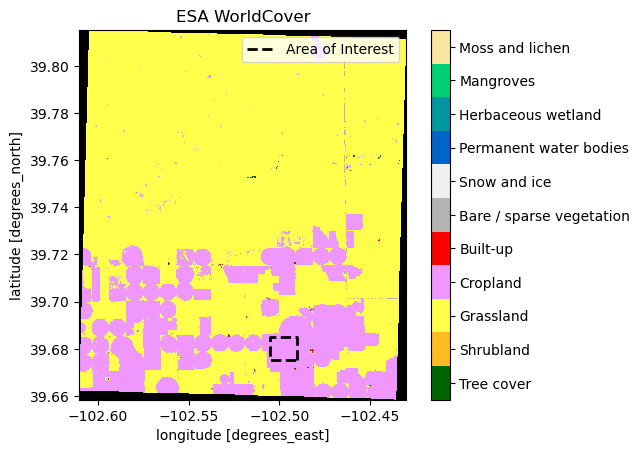

In [9]:
ax = coincident.plot.plot_esa_worldcover(dswc)
aoi.plot(ax=ax, 
         facecolor='none',
         edgecolor='black',
         linestyle="--",
         linewidth=2)
from matplotlib.lines import Line2D
custom_line = Line2D([0], [0], color='black', linestyle='--', lw=2)
ax.legend([custom_line], ['Area of Interest'], loc='upper right', fontsize=10)
ax.set_title("ESA WorldCover");

Actually read-in and download the DEMs

In [10]:
coincident.io.xarray.load_neon_dem?

Signature:
coincident.io.xarray.load_neon_dem(
    aoi: 'gpd.GeoDataFrame',
    datetime_str: 'str',
    site_id: 'str',
    product: 'str',
    res: 'int' = 1,
    clip: 'bool' = True,
) -> 'xr.DataArray'
Docstring:
Load and merge NEON LiDAR tiles (DSM, DTM, or CHM) based on an AOI by querying the NEON API.

Steps:
    1. Convert the datetime string to a month string in the format YYYY-MM.
    2. Determine appropriate UTM CRS for the AOI.
    3. Query the NEON API using a preset product code.
    4. Filter the returned files based on product type and spatial intersection.
    5. Load and optionally coarsen each GeoTIFF tile.
    6. Merge the tiles and optionally clip the mosaic to the AOI.

Parameters:
    aoi (gpd.GeoDataFrame): Area of interest geometry to query against
    datetime_str (str): Date string in YYYY-MM-DD format
    site_id (str): NEON site identifier
    product (str): Product type to load ('dsm', 'dtm', or 'chm')
    res (int): Resolution factor to coarsen DEM by (de

In [6]:
datetime_str = gf_neon.end_datetime.item()
site_id = gf_neon.id.item()
datetime_str, site_id

('2020-06-30', 'ARIK')

In [12]:
%%time
da_neon_dem = coincident.io.xarray.load_neon_dem(aoi,
                                          datetime_str=datetime_str,
                                          site_id=site_id,
                                          product="dsm")

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: 

CPU times: user 345 ms, sys: 74.4 ms, total: 420 ms
Wall time: 3.79 s


In [13]:
da_neon_dem

<xarray.DataArray 'elevation' (y: 1146, x: 1318)> Size: 6MB
dask.array<getitem, shape=(1146, 1318), dtype=float32, chunksize=(166, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 11kB 7.14e+05 7.14e+05 ... 7.153e+05 7.153e+05
  * y            (y) float64 9kB 4.395e+06 4.395e+06 ... 4.396e+06 4.396e+06
    spatial_ref  int64 8B 0

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


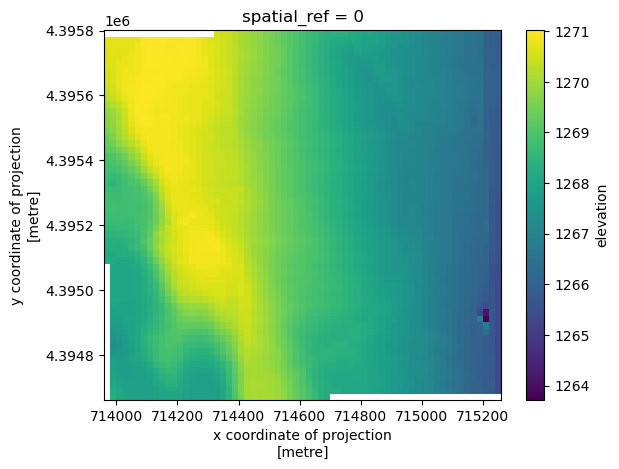

In [14]:
da_neon_dem.coarsen(x=20, y=20, boundary='trim').mean().plot.imshow();

In [16]:
coincident.io.xarray.load_usgs_dem?

Signature:
coincident.io.xarray.load_usgs_dem(
    aoi: 'gpd.GeoDataFrame',
    project: 'str',
    tnmdataset: 'str' = 'Digital Elevation Model (DEM) 1 meter',
    res: 'int' = 1,
    clip: 'bool' = True,
) -> 'xr.DataArray'
Docstring:
Load and merge USGS 1-meter DEM tiles based on an AOI by querying the TNM API.

Steps:
  1. Reproject the AOI to EPSG:4326.
  2. Extract the first geometry from the exploded AOI (to match the geometry type used in search.search).
  3. Convert the geometry to a polygon string using a private helper.
  4. Query the TNM API via the moved function in coincident.search.wesm.
  5. Filter the API items using a private helper.
  6. Load and optionally coarsen each GeoTIFF tile.
  7. Merge the DEM tiles and optionally clip the mosaic to the AOI.

Parameters:
    aoi (gpd.GeoDataFrame): Area of interest geometry to query against
    project (str): Project identifier to filter results
    tnmdataset (str): TNM dataset identifier (default "Digital Elevation Model (

In [13]:
usgs_project = gf_usgs['project'].item()
usgs_project

'CO_CentralEasternPlains_2020_D20'

In [17]:
%%time
da_usgs_dem = coincident.io.xarray.load_usgs_dem(aoi, usgs_project)

CPU times: user 819 ms, sys: 765 ms, total: 1.58 s
Wall time: 3.4 s


In [18]:
da_usgs_dem

<xarray.DataArray 'elevation' (y: 1146, x: 1317)> Size: 6MB
dask.array<getitem, shape=(1146, 1317), dtype=float32, chunksize=(1146, 1317), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 11kB 7.14e+05 7.14e+05 ... 7.153e+05 7.153e+05
  * y            (y) float64 9kB 4.396e+06 4.396e+06 ... 4.395e+06 4.395e+06
    spatial_ref  int64 8B 0

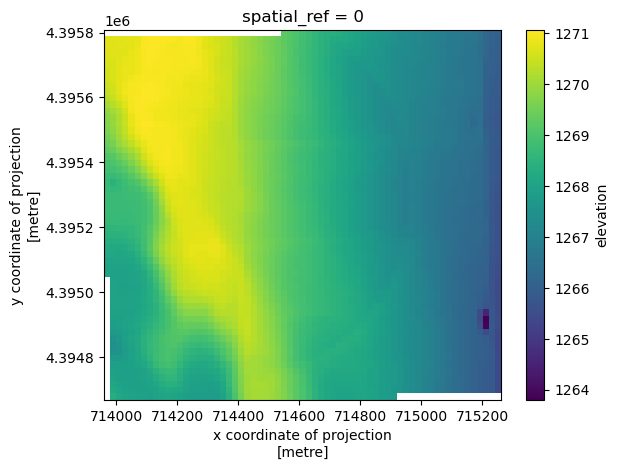

In [19]:
da_usgs_dem.coarsen(x=20, y=20, boundary='trim').mean().plot.imshow();

### Download

> ![NOTE] 
> `coincident.io.download.download_neon_dem` needs the NEON site's end_datetime, not start_datetime (separated by 1 month) to work

In [37]:
gf_neon

,id,title,start_datetime,end_datetime,product_url,geometry
0,ARIK,Arikaree River NEON,2020-06-01,2020-06-30,https://data.neonscience.org/api/v0/data/DP3.3...,"POLYGON ((-102.60902 39.69825, -102.60871 39.7..."


In [60]:
coincident.io.download.download_neon_dem?

Signature:
coincident.io.download.download_neon_dem(
    aoi: 'gpd.GeoDataFrame',
    datetime_str: 'str',
    site_id: 'str',
    product: 'str',
    output_dir: 'str' = '/tmp',
) -> 'None'
Docstring:
Download NEON LiDAR tiles (DSM, DTM, or CHM) based on an AOI by querying the NEON API.

Steps:
  1. Convert the datetime string to a month string in the format YYYY-MM.
  2. Determine appropriate UTM CRS for the AOI for spatial filtering.
  3. Query the NEON API using site ID and month.
  4. Filter the returned files based on product type and spatial intersection.
  5. Download filtered tiles with progress tracking.

Parameters:
  aoi (gpd.GeoDataFrame): Area of interest geometry to query against.
  datetime_str (str): Date string in YYYY-MM-DD format.
  site_id (str): NEON site identifier.
  product (str): Product type to download ('dsm', 'dtm', or 'chm').
  output_dir (str): Directory path where tiles will be downloaded (default "/tmp").

Returns:
  returns None after downloading files

In [38]:
local_output_dir = "/home/jehayes/coincident/local_data" # in our .gitignore
coincident.io.download.download_neon_dem(aoi=aoi,
                                        datetime_str=gf_neon.end_datetime.item(),
                                        site_id=gf_neon.id.item(),
                                        product="dsm",
                                        output_dir=local_output_dir)

In [61]:
coincident.io.download.download_usgs_dem?

Signature:
coincident.io.download.download_usgs_dem(
    aoi: 'gpd.GeoDataFrame',
    project: 'str',
    output_dir: 'str' = '/tmp',
    save_parquet: 'bool' = True,
    tnmdataset: 'str' = 'Digital Elevation Model (DEM) 1 meter',
) -> 'None'
Docstring:
Download USGS 1-meter DEM tiles based on an AOI by querying the TNM API.
https://data.usgs.gov/datacatalog/data/USGS:77ae0551-c61e-4979-aedd-d797abdcde0e

Steps:
  1. Reproject the AOI to EPSG:4326.
  2. Extract the first geometry from the exploded AOI.
  3. Convert the geometry to a polygon string.
  4. Query the TNM API and filter results.
  5. Optionally save metadata as geoparquet.
  6. Download each tile with progress tracking.

Parameters
----------
aoi : gpd.GeoDataFrame
    Area of interest geometry.
project : str
    Project identifier to filter results.
path : str
    Directory path where tiles will be downloaded.
save_parquet : bool, optional
    Whether to save metadata as geoparquet (default True).
tnmdataset : str, option

In [39]:
coincident.io.download.download_usgs_dem(aoi=aoi,
                                        project=usgs_project,
                                        output_dir=local_output_dir,
                                        save_parquet=True # save a STAC-like geoparquet of the tiles you download
                                        )

Finally, you can grab the LPC tile metadata

In [62]:
coincident.io.download.fetch_neon_lpc_tiles?

Signature:
coincident.io.download.fetch_neon_lpc_tiles(
    aoi: 'gpd.GeoDataFrame',
    datetime_str: 'str',
    site_id: 'str',
    output_dir: 'str | None' = None,
) -> 'gpd.GeoDataFrame'
Docstring:
Fetch NEON LPC tile bboxes as a GeoDataFrame (in EPSG:4326),
optionally writing to disk as a GeoJSON.
This function uses regex and assumes a tile size of 1km for all NEON tiles
given the necessity for client-side spatial filtering and no PDAL

Steps:
  1. Convert the datetime string to YYYY-MM for the API query.
  2. Determine the appropriate UTM CRS for spatial filtering.
  3. Query the NEON API for LPC files.
  4. Filter files whose 1km tile intersects the AOI in UTM.
  5. Parse each filename for its lower left UTM corner, build a 1km box.
  6. Assemble into a GeoDataFrame and reproject to EPSG:4326.
  7. If `output_dir` is provided, save the GeoDataFrame as `lpc_tiles.geojson`.

Parameters:
  aoi (gpd.GeoDataFrame): AOI geometries.
  datetime_str (str): Date in “YYYY-MM-DD” format.
  

In [9]:
%%time
gf_neon_lpc_tiles = coincident.io.download.fetch_neon_lpc_tiles(aoi=aoi,
                                        datetime_str=gf_neon.start_datetime.item(),
                                        site_id=gf_neon.id.item())

CPU times: user 99.9 ms, sys: 753 μs, total: 101 ms
Wall time: 357 ms


In [10]:
gf_neon_lpc_tiles

,name,url,geometry
0,NEON_D10_ARIK_DP1_715000_4395000_classified_po...,https://storage.googleapis.com/neon-aop-produc...,"POLYGON ((-102.48149 39.67754, -102.48116 39.6..."
1,NEON_D10_ARIK_DP1_714000_4394000_classified_po...,https://storage.googleapis.com/neon-aop-produc...,"POLYGON ((-102.49347 39.66879, -102.49314 39.6..."
2,NEON_D10_ARIK_DP1_713000_4395000_classified_po...,https://storage.googleapis.com/neon-aop-produc...,"POLYGON ((-102.50479 39.67804, -102.50447 39.6..."
3,NEON_D10_ARIK_DP1_713000_4394000_classified_po...,https://storage.googleapis.com/neon-aop-produc...,"POLYGON ((-102.50511 39.66904, -102.50479 39.6..."
4,NEON_D10_ARIK_DP1_714000_4395000_classified_po...,https://storage.googleapis.com/neon-aop-produc...,"POLYGON ((-102.49314 39.67779, -102.49281 39.6..."
5,NEON_D10_ARIK_DP1_715000_4394000_classified_po...,https://storage.googleapis.com/neon-aop-produc...,"POLYGON ((-102.48182 39.66854, -102.48149 39.6..."


In [12]:
coincident.io.download.fetch_usgs_lpc_tiles?

Signature:
coincident.io.download.fetch_usgs_lpc_tiles(
    aoi: 'gpd.GeoDataFrame',
    project: 'str',
    tnmdataset: 'str' = 'Lidar Point Cloud (LPC)',
    output_dir: 'str | None' = None,
) -> 'gpd.GeoDataFrame'
Docstring:
Query USGS TNMAccess for LPC products intersecting an AOI, assemble their
bounding boxes into a GeoDataFrame (EPSG:4326), and optionally write to disk.

Steps:
  1. Reproject AOI to EPSG:4326 and explode to a single geometry.
  2. Convert that geometry into the TNM APIs `polygon` string format.
  3. Call `query_tnm_api` to retrieve all LPC products (LAS/LAZ) in the AOI.
  4. Filter the returned items by matching `project` via `_filter_items_by_project`.
  5. Build a Shapely box from each items `boundingBox` coordinates.
  6. Assemble into a GeoDataFrame in EPSG:4326.
  7. If `output_dir` is provided, save as `usgs_lpc_products.geojson`.

Parameters:
  aoi (gpd.GeoDataFrame): Area of interest.
  project (str): A substring or identifier used to filter product titl

In [14]:
%%time
gf_usgs_lpc_tiles = coincident.io.download.fetch_usgs_lpc_tiles(aoi=aoi,
                                                                project=usgs_project)              

CPU times: user 19.9 ms, sys: 0 ns, total: 19.9 ms
Wall time: 1.07 s


In [15]:
gf_usgs_lpc_tiles

,sourceId,downloadURL,geometry
0,5fded821d34e30b9123e230c,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,"POLYGON ((-102.50479 39.66904, -102.50479 39.6..."
1,5fded821d34e30b9123e230e,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,"POLYGON ((-102.50447 39.67804, -102.50447 39.6..."
2,5fded82fd34e30b9123e235a,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,"POLYGON ((-102.49314 39.66879, -102.49314 39.6..."
3,5fded830d34e30b9123e235c,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,"POLYGON ((-102.49281 39.67779, -102.49281 39.6..."
4,5fded837d34e30b9123e23a8,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,"POLYGON ((-102.48149 39.66854, -102.48149 39.6..."
5,5fded837d34e30b9123e23aa,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,"POLYGON ((-102.48116 39.67754, -102.48116 39.6..."


In [17]:
m = gf_usgs_lpc_tiles.explore(color='black')
gf_neon_lpc_tiles.explore(m=m)

## Examples for NCALM and NOAA

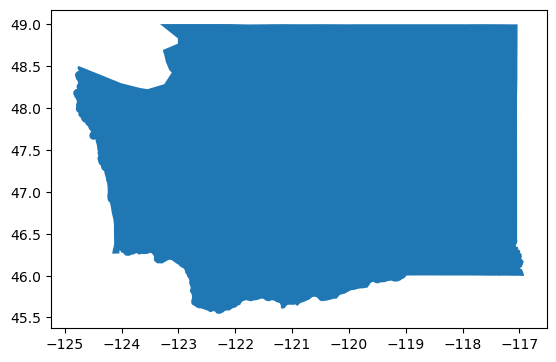

In [18]:
aoi = gpd.read_file(
    "https://raw.githubusercontent.com/unitedstates/districts/refs/heads/gh-pages/states/WA/shape.geojson"
)
aoi.plot();

In [19]:
gf_ncalm = coincident.search.search(dataset="ncalm", intersects=aoi, datetime=["2018-09-19"])

In [20]:
gf_ncalm

,id,name,title,start_datetime,end_datetime,geometry
0,OTLAS.072019.6339.1,WA18_Wall,"High-Resolution Mapping of Goat Rock Volcano, WA",2018-09-19,2018-09-20,"POLYGON ((-121.46701 46.48376, -121.45914 46.4..."


Now, let's subset to a small AOI for convenience sake

In [21]:
buffer_size = 0.01
centroid = gf_ncalm.centroid
mini_aoi = gpd.GeoDataFrame(
    geometry=[box(centroid.x-buffer_size, centroid.y-buffer_size, 
                 centroid.x+buffer_size, centroid.y+buffer_size)],
    crs="EPSG:4326"
)

/tmp/ipykernel_28372/1062712956.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gf_ncalm.centroid
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


In [44]:
m = gf_ncalm.explore()
mini_aoi.explore(m=m, color='red')

> ![NOTE]
> The NCALM DEMs are not tiled, so reading in the data and downloading takes a longer time

In [57]:
coincident.io.xarray.load_ncalm_dem?

Signature:
coincident.io.xarray.load_ncalm_dem(
    aoi: 'gpd.GeoDataFrame',
    dataset_id: 'str | int',
    product: 'str',
    res: 'int' = 1,
    clip: 'bool' = True,
    return_single: 'bool' = True,
) -> 'xr.DataArray | list[xr.DataArray]'
Docstring:
Load NCALM DEM (DTM or DSM) tiles directly from OpenTopography S3 and return as xarray DataArray.

NCALM provides:
  - DTM (bare-earth) with file code GEG in folder suffix '_be'
  - DSM (first-return) with file code GEF in folder suffix '_hh'

Parameters
----------
aoi : geopandas.GeoDataFrame
    Area of interest geometries (in EPSG:4326).
dataset_id : str or int
    NCALM dataset identifier (e.g., 'WA18_Wall').
product : str
    'dtm' for bare-earth, 'dsm' for first-return.
res : int, optional
    Factor to coarsen the DEM (default 1 = no coarsening).
clip : bool, optional
    Whether to clip final mosaic to the AOI (default True).
return_single : bool, optional
    If True, return a single merged DataArray. If False, return a list

In [51]:
%%time
da_ncalm_dtm = coincident.io.xarray.load_ncalm_dem(aoi=mini_aoi, product='dtm', dataset_id=gf_ncalm['name'].item())

CPU times: user 8.1 s, sys: 2.69 s, total: 10.8 s
Wall time: 41.8 s


In [52]:
da_ncalm_dtm

<xarray.DataArray 'elevation' (y: 2254, x: 1579)> Size: 14MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 13kB 6.226e+05 6.226e+05 ... 6.242e+05 6.242e+05
  * y            (y) float64 18kB 5.152e+06 5.152e+06 ... 5.15e+06 5.15e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

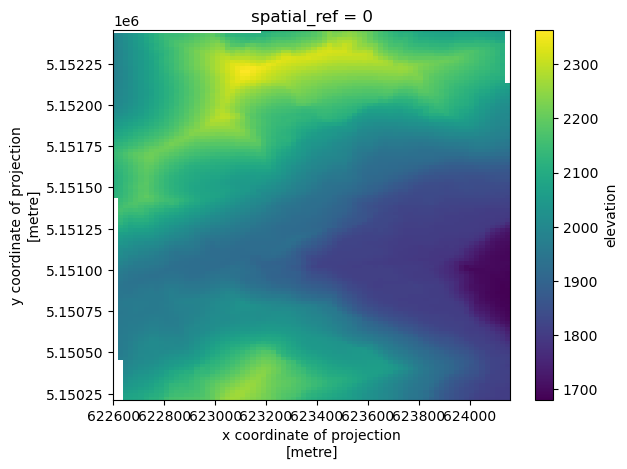

In [55]:
da_ncalm_dtm.coarsen(x=20, y=20, boundary='trim').mean().plot.imshow();

In [56]:
coincident.io.download.download_ncalm_dem?

Signature:
coincident.io.download.download_ncalm_dem(
    aoi: 'gpd.GeoDataFrame',
    dataset_id: 'str | int',
    product: 'str',
    output_dir: 'str' = '/tmp',
) -> 'None'
Docstring:
Download NCALM (or OpenTopo user-hosted) data from OpenTopography S3 based on a dataset identifier and an AOI.
Your dataset identifier will be the 'name' column from coincident.search.search(dataset="ncalm")

NOTE: NCALM provides both DSMs and DTMs
e.g. WA18_Wall/WA18_Wall_be/WALL_GEG_1M.tif vs WA18_Wall/WA18_Wall_hh/WALL_GEF_1M.tif
where the be suffix stands for "bare earth" and the hh suffix stands for "highest hits" (or first return)
GEG = Grid Elevation (Ground) or the the bare earth elevation grid
GEF = Grid Elevation (First return) or the the first return elevation grid

For DEM  data, the function lists all available DEM tiles under the
dataset prefix, downloads each tile, reprojects it (if necessary) to the AOI's local UTM
CRS, clips it to the AOI, and then saves the clipped DEM as a GeoTIFF fi

In [59]:
%%time
coincident.io.download.download_ncalm_dem(aoi=mini_aoi,
                                        dataset_id=gf_ncalm['name'].item(),
                                        product='dtm',
                                        output_dir=local_output_dir)

CPU times: user 8.31 s, sys: 2.96 s, total: 11.3 s
Wall time: 55.2 s


In [25]:
coincident.io.download.fetch_ncalm_lpc_tiles?

Signature:
coincident.io.download.fetch_ncalm_lpc_tiles(
    aoi: 'gpd.GeoDataFrame',
    dataset_name,
    output_dir: 'str | None' = None,
    download: 'bool' = False,
) -> 'gpd.GeoDataFrame'
Docstring:
Fetch NCALM LPC (1 km LAZ) tiles intersecting an AOI from the OpenTopography 'pc-bulk' bucket,
optionally downloading them to disk.

Steps:
  1. Reproject AOI to its local UTM CRS for accurate spatial filtering.
  2. List all .laz keys under pc-bulk/{dataset_id}/.
  3. Client-side filter: extract easting/northing from each filename, build a 1 km box,
     keep only tiles that intersect the AOI in UTM.
  4. Build a GeoDataFrame with columns ['key','url','geometry'] and reproject back to EPSG:4326.
  5. If download=True, write each tile to output_dir.

Parameters
----------
aoi : geopandas.GeoDataFrame
    AOI geometries (any CRS, but assumed geographic or projected).
dataset_name : str
    NCALM project shortname (e.g. "WA18_Wall").
output_dir : str | None
    If provided, directory t

In [28]:
%%time
gf_ncalm_lpc_tiles = coincident.io.download.fetch_ncalm_lpc_tiles(aoi=mini_aoi,
                                                                dataset_name=gf_ncalm.name.item())

CPU times: user 148 ms, sys: 597 μs, total: 149 ms
Wall time: 364 ms


In [29]:
gf_ncalm_lpc_tiles

,key,url,geometry
0,WA18_Wall/622000_5150000.laz,https://opentopography.s3.sdsc.edu/pc-bulk/WA1...,"POLYGON ((-121.39723 46.49234, -121.39697 46.5..."
1,WA18_Wall/622000_5151000.laz,https://opentopography.s3.sdsc.edu/pc-bulk/WA1...,"POLYGON ((-121.39697 46.50133, -121.3967 46.51..."
2,WA18_Wall/622000_5152000.laz,https://opentopography.s3.sdsc.edu/pc-bulk/WA1...,"POLYGON ((-121.3967 46.51033, -121.39644 46.51..."
3,WA18_Wall/623000_5150000.laz,https://opentopography.s3.sdsc.edu/pc-bulk/WA1...,"POLYGON ((-121.3842 46.49216, -121.38394 46.50..."
4,WA18_Wall/623000_5151000.laz,https://opentopography.s3.sdsc.edu/pc-bulk/WA1...,"POLYGON ((-121.38394 46.50115, -121.38367 46.5..."
5,WA18_Wall/623000_5152000.laz,https://opentopography.s3.sdsc.edu/pc-bulk/WA1...,"POLYGON ((-121.38367 46.51015, -121.3834 46.51..."
6,WA18_Wall/624000_5150000.laz,https://opentopography.s3.sdsc.edu/pc-bulk/WA1...,"POLYGON ((-121.37118 46.49197, -121.37091 46.5..."
7,WA18_Wall/624000_5151000.laz,https://opentopography.s3.sdsc.edu/pc-bulk/WA1...,"POLYGON ((-121.37091 46.50097, -121.37064 46.5..."
8,WA18_Wall/624000_5152000.laz,https://opentopography.s3.sdsc.edu/pc-bulk/WA1...,"POLYGON ((-121.37064 46.50996, -121.37037 46.5..."


In [30]:
m = gf_ncalm.explore()
gf_ncalm_lpc_tiles.explore(m=m, color='red')

Finally, NOAA

In [31]:
aoi = gpd.read_file(
    "https://raw.githubusercontent.com/unitedstates/districts/refs/heads/gh-pages/states/FL/shape.geojson"
)
gf_noaa = coincident.search.search(dataset="noaa", intersects=aoi, datetime=["2022-10-27"])

In [32]:
buffer_size = 0.02
centroid = gf_noaa.centroid
mini_aoi = gpd.GeoDataFrame(
    geometry=[box(centroid.x-buffer_size, centroid.y-buffer_size, 
                 centroid.x+buffer_size, centroid.y+buffer_size)],
    crs="EPSG:4326"
)

/tmp/ipykernel_28372/2944980197.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gf_noaa.centroid
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


In [ ]:
m = gf_noaa.explore()
mini_aoi.explore(m=m, color='red')

the name and id being identical is expected

In [34]:
gf_noaa

,id,name,title,start_datetime,end_datetime,geometry
0,10149,10149,"2022 NOAA NGS Topobathy Lidar: Big Bend WMA, FL",2022-10-27,2022-11-29,"POLYGON ((-83.4654 29.36713, -83.35291 29.4196..."


> [!NOTE]  

> Our coincident.search.search(dataset="noaa") returns the dataset ids "Lidar Datasets at NOAA Digital Coast" whereas coincident.io.xarray.load_noaa_dem() requires the ids from the "Imagery and Elevation Raster Datasets at NOAA Digital Coast" dataset. The corresponding elevation raster dataset id is the same as the lidar dataset id + 1. 

> e.g. "Great Bay NERR UAS Lidar" has id 10175 for lidar data and id 10176 for dem data

In [35]:
noaa_dem_id = int(gf_noaa.id.item())+1
print(f"NOAA LiDAR id: {gf_noaa.id.item()}  NOAA DEM id: {noaa_dem_id}")

NOAA LiDAR id: 10149  NOAA DEM id: 10150


```{warning}
The larger the NOAA flight, the longer the below function takes regardless of your input AOI
```

In [39]:
coincident.io.xarray.load_noaa_dem?

Signature:
coincident.io.xarray.load_noaa_dem(
    aoi: 'gpd.GeoDataFrame',
    dataset_id: 'str | int',
    res: 'int' = 1,
    clip: 'bool' = True,
) -> 'xr.DataArray'
Docstring:
Process NOAA coastal lidar DEM data from S3 based on a dataset identifier and an AOI.
Returns an xarray DataArray with elevation values clipped to the AOI without downloading files locally.

Parameters
----------
aoi : geopandas.GeoDataFrame
    Area of interest geometry (assumed to be in EPSG:4326 or any other CRS that will be reprojected).
dataset_id : str or int
    NOAA dataset identifier (e.g., "8431" or "6260").
res : int, optional
    Resolution factor. If greater than 1, the data will be coarsened by this factor. Defaults to 1.
clip : bool, optional
    Whether to clip the output mosaic to the AOI. Defaults to True.

Returns
-------
xarray.DataArray
    An xarray DataArray containing DEM values clipped to the AOI.

Notes
-----
This function queries only the raster headers from S3 to retrieve bounds i

In [36]:
%%time
da_noaa_dem = coincident.io.xarray.load_noaa_dem(mini_aoi,noaa_dem_id)

CPU times: user 4 s, sys: 1.21 s, total: 5.21 s
Wall time: 29 s


In [37]:
da_noaa_dem

<xarray.DataArray 'elevation' (y: 3909, x: 3964)> Size: 62MB
dask.array<getitem, shape=(3909, 3964), dtype=float32, chunksize=(3909, 2625), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 32kB 2.237e+05 2.237e+05 ... 2.276e+05 2.276e+05
  * y            (y) float64 31kB 3.304e+06 3.304e+06 ... 3.3e+06 3.3e+06
    spatial_ref  int64 8B 0

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


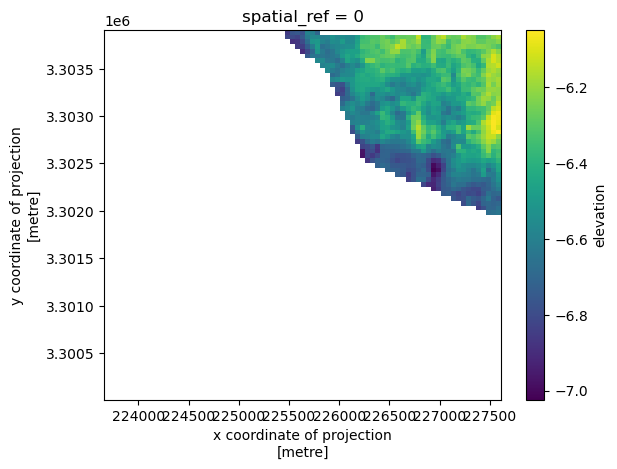

In [38]:
da_noaa_dem.coarsen(x=50, y=50, boundary='trim').mean().plot.imshow();

In [40]:
coincident.io.download.download_noaa_dem?

Signature:
coincident.io.download.download_noaa_dem(
    aoi: 'gpd.GeoDataFrame',
    dataset_id: 'str | int',
    output_dir: 'str' = '/tmp',
    res: 'int' = 1,
    clip: 'bool' = True,
) -> 'None'
Docstring:
Download NOAA coastal lidar DEM data from S3 based on a dataset identifier and an AOI.
For each tile that intersects the AOI, the tile is downloaded, optionally coarsened and clipped,
then saved as a GeoTIFF file in the specified output directory.

Parameters
----------
aoi : geopandas.GeoDataFrame
    Area of interest geometry (assumed to be in EPSG:4326 or any other CRS that will be reprojected).
dataset_id : str or int
    NOAA dataset identifier (e.g., "8431" or "6260").
output_dir : str, optional
    Directory to save downloaded output files. Defaults to "/tmp".
res : int, optional
    Resolution factor. If greater than 1, the DEMs will be coarsened by this factor. Defaults to 1.
clip : bool, optional
    Whether to clip each DEM tile to the AOI. Defaults to True.

Returns


In [43]:
%%time
coincident.io.download.download_noaa_dem(aoi=mini_aoi,
                                        dataset_id=noaa_dem_id,
                                        output_dir=local_output_dir)

CPU times: user 4.79 s, sys: 770 ms, total: 5.56 s
Wall time: 18.8 s


In [44]:
coincident.io.download.fetch_noaa_lpc_tiles?

Signature:
coincident.io.download.fetch_noaa_lpc_tiles(
    aoi: 'gpd.GeoDataFrame',
    dataset_id: 'str',
    output_dir: 'str | None' = None,
) -> 'gpd.GeoDataFrame'
Docstring:
Fetch NOAA DEM tile geometries as a GeoDataFrame (in EPSG:4326),
optionally writing to disk as a GeoJSON.

This function processes NOAA DEM LAZ files, extracts tile geometries based on filename patterns,
filters them by intersection with the provided AOI, and returns a GeoDataFrame in EPSG:4326.

NOTE: regex was necessary here for client-side spatial filtering, otherwise you'd have to make network
requests to thousands of laz files

Steps:
  1. Estimate the appropriate UTM CRS for spatial filtering.
  2. Query the NOAA dataset for LAZ files.
  3. Extract easting and northing from filenames using regex.
  4. Determine tile dimensions by analyzing neighboring tiles.
  5. Construct tile geometries and filter by AOI intersection.
  6. Assemble into a GeoDataFrame and reproject to EPSG:4326.
  7. If output_dir is 

In [46]:
%%time
gf_noaa_lpc_tiles = coincident.io.download.fetch_noaa_lpc_tiles(aoi=mini_aoi,
                                                                dataset_id=gf_noaa.id.item())

CPU times: user 2.29 s, sys: 0 ns, total: 2.29 s
Wall time: 4.55 s


In [47]:
gf_noaa_lpc_tiles

,name,url,geometry
0,20221114_224000e_3303500n.copc.laz,https://noaa-nos-coastal-lidar-pds.s3.amazonaw...,"POLYGON ((-83.85106 29.83127, -83.85119 29.835..."
1,20221114_224500e_3303000n.copc.laz,https://noaa-nos-coastal-lidar-pds.s3.amazonaw...,"POLYGON ((-83.84576 29.82687, -83.84589 29.831..."
2,20221114_224500e_3303500n.copc.laz,https://noaa-nos-coastal-lidar-pds.s3.amazonaw...,"POLYGON ((-83.84589 29.83138, -83.84602 29.835..."
3,20221114_225000e_3303000n.copc.laz,https://noaa-nos-coastal-lidar-pds.s3.amazonaw...,"POLYGON ((-83.84059 29.82698, -83.84072 29.831..."
4,20221114_225000e_3303500n.copc.laz,https://noaa-nos-coastal-lidar-pds.s3.amazonaw...,"POLYGON ((-83.84072 29.83149, -83.84085 29.836..."
5,20221114_225500e_3302500n.copc.laz,https://noaa-nos-coastal-lidar-pds.s3.amazonaw...,"POLYGON ((-83.8353 29.82259, -83.83543 29.8270..."
6,20221114_225500e_3303000n.copc.laz,https://noaa-nos-coastal-lidar-pds.s3.amazonaw...,"POLYGON ((-83.83543 29.82709, -83.83555 29.831..."
7,20221114_225500e_3303500n.copc.laz,https://noaa-nos-coastal-lidar-pds.s3.amazonaw...,"POLYGON ((-83.83555 29.8316, -83.83568 29.8361..."
8,20221114_226000e_3302000n.copc.laz,https://noaa-nos-coastal-lidar-pds.s3.amazonaw...,"POLYGON ((-83.83 29.81819, -83.83013 29.8227, ..."
9,20221114_226000e_3302500n.copc.laz,https://noaa-nos-coastal-lidar-pds.s3.amazonaw...,"POLYGON ((-83.83013 29.8227, -83.83026 29.8272..."


In [48]:
m = gf_noaa.explore()
gf_noaa_lpc_tiles.explore(m=m, color='red')